# Settings

In [1]:
%env TF_KERAS = 1
import os
sep_local = os.path.sep

import sys
sys.path.append('..'+sep_local+'..')
print(sep_local)

env: TF_KERAS=1
\


In [2]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [3]:
os.chdir('..'+sep_local+'..'+sep_local+'..')
print(os.getcwd())

C:\Users\Khalid\Documents\projects\GM\Generative_Models


# Dataset loading

In [4]:
dataset_name='pokemon'

In [5]:
IMG_DIR = 'C:\\Users\\Khalid\\Documents\projects\\pokemon\DS06\\'
VAL_PCT = 20
VAL_FORMAT = 'png'

In [6]:
from training.generators.file_image_generator import create_image_lists, get_generators

Using TensorFlow backend.


In [7]:
imgs_list = create_image_lists(
    image_dir=IMG_DIR, 
    validation_pct=VAL_PCT, 
    valid_imgae_formats=VAL_FORMAT
)

  DEBUG    | Looking for images in 'all'


  INFO     | 809 file found


In [8]:
inputs_shape= IMG_SIZE=(200, 200, 3)
BATCH_SIZE = 32
latent_dim = 32
intermediate_dim = 32

In [9]:
train_gen, test_gen = get_generators(
    images_list=imgs_list, 
    image_dir=IMG_DIR, 
    image_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode=None
)

  INFO     | Found 662 training files


  INFO     | Found 147 validation files


In [10]:
import tensorflow as tf

In [11]:
import random
import numpy as np
from utils.augmentation.augmentor import operations, do_operation
def batch_augmentor(batch, operation=None):
    if operation is None:
        rn = random.randint(0, len(operations)-1)
        #print(operations[rn]())
        operation = operations[rn]()
    return np.array([do_operation(operation, image) for image in batch])

def generator_augmentor(generator): 
    while True:
        yield batch_augmentor(next(generator))

In [12]:
batch = next(generator_augmentor(train_gen))

In [13]:
import matplotlib.pyplot as plt

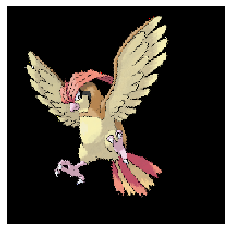

In [14]:
plt.imshow(batch[2])
plt.axis('off');
plt.show()

In [15]:
train_ds = tf.data.Dataset.from_generator(
    lambda: generator_augmentor(train_gen), 
    output_types=tf.float32 ,
    output_shapes=tf.TensorShape((BATCH_SIZE, ) + IMG_SIZE)
)

test_ds = tf.data.Dataset.from_generator(
    lambda: generator_augmentor(test_gen), 
    output_types=tf.float32 ,
    output_shapes=tf.TensorShape((BATCH_SIZE, ) + IMG_SIZE)
)


In [16]:
_instance_scale=1.0
for data in generator_augmentor(train_gen):
    _instance_scale = float(data[0].max())
    break

In [17]:
_instance_scale

1.0

In [18]:
import numpy as np
from collections.abc import Iterable

In [19]:
if isinstance(inputs_shape, Iterable):
    _outputs_shape = np.prod(inputs_shape)

In [20]:
_outputs_shape

120000

# Model's Layers definition

In [21]:
enc_lays = [tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=latent_dim)]

dec_lays = [tf.keras.layers.Dense(units=latent_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=_outputs_shape),
            tf.keras.layers.Reshape(inputs_shape)]

# Model definition

In [22]:
model_name = dataset_name+'_inputs_augmented_AE_Dense_reconst_ell'
recording_dir='recording'+sep_local+model_name

In [23]:
from training.autoencoding_basic.autoencoders.autoencoder import autoencoder as AE

In [24]:
inputs_shape=IMG_SIZE

In [25]:
variables_params = \
[
    {
        'name': 'inference', 
        'inputs_shape':inputs_shape,
        'outputs_shape':latent_dim,
        'layers': enc_lays
    }

    ,
    
        {
        'name': 'generative', 
        'inputs_shape':latent_dim,
        'outputs_shape':inputs_shape,
        'layers':dec_lays
    }
]

In [26]:
from utils.data_and_files.file_utils import create_if_not_exist

In [27]:
_restore = os.path.join(recording_dir, 'var_save_dir')

In [28]:
create_if_not_exist(_restore)
_restore

'recording\\pokemoninputs_augmented_AE_Dense_reconst_ell\\var_save_dir'

In [29]:
#to restore trained model, set filepath=_restore

In [30]:
ae = AE( 
    name=model_name,
    inputs_shape=inputs_shape,
    outputs_shape=inputs_shape,
    latent_dim=latent_dim,
    batch_size=BATCH_SIZE,
    variables_params=variables_params, 
    filepath=None
    )

Model: "inference"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inference_inputs (InputLayer [(None, 200, 200, 3)]     0         
_________________________________________________________________
dense (Dense)                (None, 200, 200, 32)      128       
_________________________________________________________________
dense_1 (Dense)              (None, 200, 200, 32)      1056      
_________________________________________________________________
flatten (Flatten)            (None, 1280000)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                40960032  
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0 

  WARNING  | None


Model: "generative"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generative_inputs (InputLaye [(None, 32)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 120000)            3960000   
_________________________________________________________________
reshape (Reshape)            (None, 200, 200, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 200, 3)       12        
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 200, 3)       0

  WARNING  | None


In [31]:
#ae.compile(metrics=None)
ae.compile()

Model: "pokemoninputs_augmented_AE_Dense_reconst_ell"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inference_inputs (InputLayer [(None, 200, 200, 3)]     0         
_________________________________________________________________
inference (Model)            (None, 32)                40961344  
_________________________________________________________________
generative (Model)           (None, 200, 200, 3)       3962124   
_________________________________________________________________
tf_op_layer_x_logits (Tensor [(None, 200, 200, 3)]     0         
Total params: 44,923,468
Trainable params: 44,923,398
Non-trainable params: 70
_________________________________________________________________
None


# Callbacks

In [32]:
from training.callbacks.progress_bar import NotebookPrograssBar
from training.callbacks.sample_generation import SampleGeneration
from training.callbacks.save_model import ModelSaver

In [33]:
progbar = NotebookPrograssBar(leave_outer=False)

In [34]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=1e-12, 
    patience=5, 
    verbose=1, 
    restore_best_weights=True
)

In [35]:
ms = ModelSaver(filepath=_restore,save_freq=5)

In [36]:
csv_dir = os.path.join(recording_dir, 'csv_dir')
create_if_not_exist(csv_dir)
csv_dir = os.path.join(csv_dir, ae.name+'.csv')
csv_log = tf.keras.callbacks.CSVLogger(csv_dir, append=True)
csv_dir

'recording\\pokemoninputs_augmented_AE_Dense_reconst_ell\\csv_dir\\pokemoninputs_augmented_AE_Dense_reconst_ell.csv'

In [37]:
image_gen_dir = os.path.join(recording_dir, 'image_gen_dir')
create_if_not_exist(image_gen_dir)

In [38]:
sg = SampleGeneration(latent_shape=latent_dim, filepath=image_gen_dir, gen_freq=5, save_img=True, gray_plot=False)

In [39]:
import numpy as np

# Model Training

In [ ]:
ae.fit(
    x=train_ds,
    input_kw=None,
    steps_per_epoch=900,
    epochs=int(1e6), 
    verbose=0,
    callbacks=[progbar, es, ms, csv_log, sg],
    workers=-1,
    use_multiprocessing=True,
    validation_data=test_ds,
    validation_steps=100
)